In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    cohen_kappa_score,
    confusion_matrix,
    mean_squared_error,
    mean_absolute_percentage_error,
    roc_auc_score,
    roc_curve
)
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Load the Dataset
data = pd.read_csv(r"D:\CS6501\PROJECT WORKS\Final Dataset-v.1\Dataset_3.csv")
print("Dataset Loaded:")
print(data.head())

Dataset Loaded:
   id  Time     feat1     feat2     feat3     feat4     feat5     feat6  \
0   0   0.0  2.074329 -0.129425 -1.137418  0.412846 -0.192638 -1.210144   
1   1   0.0  1.998827 -1.250891 -0.520969 -0.894539 -1.122528 -0.270866   
2   2   0.0  0.091535  1.004517 -0.223445 -0.435249  0.667548 -0.988351   
3   3   0.0  1.979649 -0.184949 -1.064206  0.120125 -0.215238 -0.648829   
4   4   0.0  1.025898 -0.171827  1.203717  1.243900 -0.636572  1.099074   

      feat7     feat8  ...    feat21    feat22    feat23    feat24    feat25  \
0  0.110697 -0.263477  ... -0.334701 -0.887840  0.336701 -0.110835 -0.291459   
1 -1.029289  0.050198  ...  0.054848 -0.038367  0.133518 -0.461928 -0.465491   
2  0.948146 -0.084789  ... -0.326725 -0.803736  0.154495  0.951233 -0.506919   
3 -0.087826 -0.035367  ... -0.095514 -0.079792  0.167701 -0.042939  0.000799   
4 -0.938651  0.569239  ...  0.099157  0.608908  0.027901 -0.262813  0.257834   

     feat26    feat27    feat28  Transaction_Amount 

In [3]:
# Dataset Overview
print("\nDataset Summary:")
print(data.describe())  # Statistical summary of the dataset
print("\nDataset Info:")
print(data.info())  # Dataset information


Dataset Summary:
                  id           Time          feat1          feat2  \
count  150000.000000  150000.000000  150000.000000  150000.000000   
mean    74999.500000   49785.422340       0.069456      -0.003674   
std     43301.414527   18733.655609       1.346553       1.161502   
min         0.000000       0.000000     -22.173926     -44.247914   
25%     37499.750000   39411.000000      -0.844248      -0.621724   
50%     74999.500000   53785.000000       0.671327       0.003677   
75%    112499.250000   63833.000000       1.171271       0.753340   
max    149999.000000   73899.000000       2.390816      16.068473   

               feat3          feat4          feat5          feat6  \
count  150000.000000  150000.000000  150000.000000  150000.000000   
mean        0.739860       0.104810      -0.254623       0.151934   
std         1.012801       1.230909       1.048268       1.182964   
min       -19.088980      -5.069484     -21.090735     -25.659750   
25%         0.1

In [4]:
# Remove Duplicate Rows
data = data.drop_duplicates()
print(f"\nDataset shape after removing duplicates: {data.shape}")


Dataset shape after removing duplicates: (150000, 32)


In [5]:
# Handle Missing Values
data.fillna(data.mean(), inplace=True)
print("Missing values handled.")

Missing values handled.


In [6]:
# Remove outliers
def remove_outliers(data):
    for col in data.select_dtypes(include=['number']).columns:
        if col != 'IsFraud':  # Do not remove rows affecting the target variable
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            data = data[(data[col] >= lower_bound) | (data['IsFraud'] == 1)]
    return data

# Apply the outlier removal function
data_cleaned = remove_outliers(data)
print(f"Cleaned Dataset Class Distribution:")
print(data_cleaned['IsFraud'].value_counts())

Cleaned Dataset Class Distribution:
IsFraud
0    99268
1      269
Name: count, dtype: int64


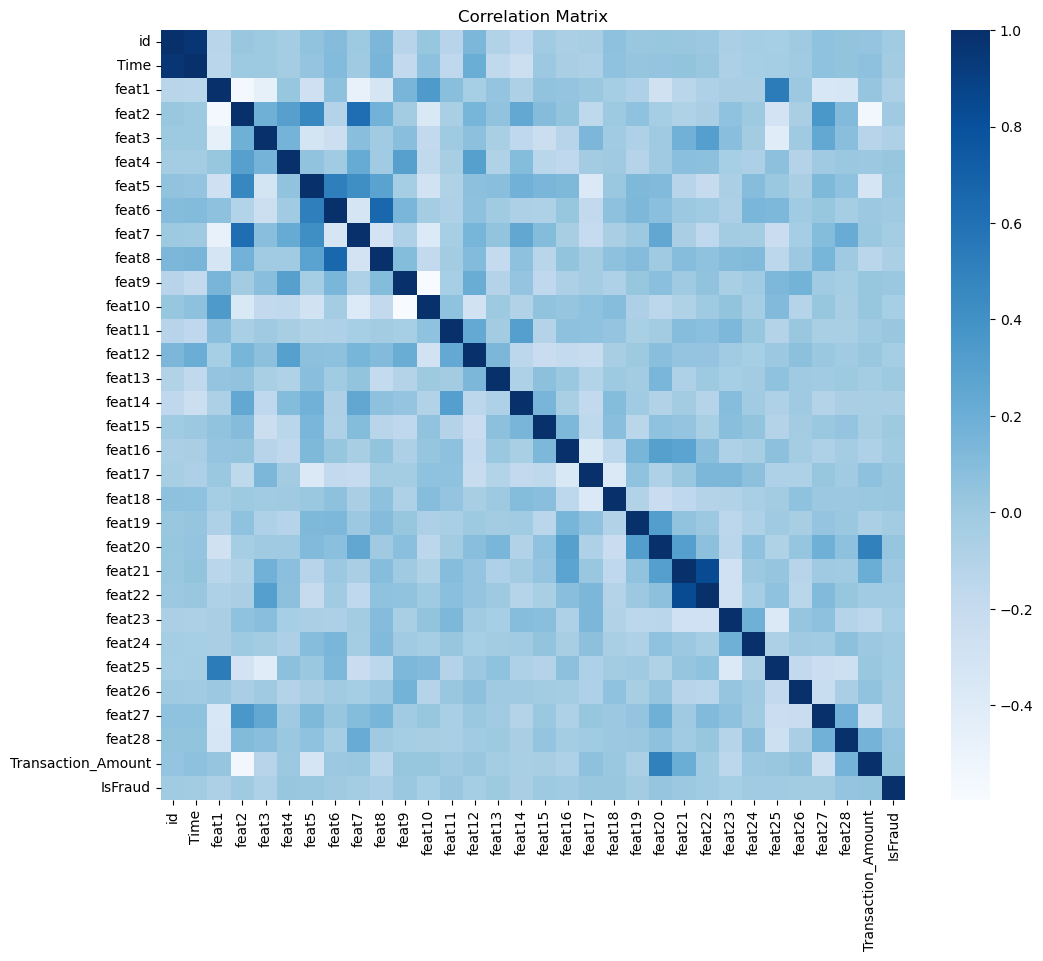

In [7]:
# Display Correlation Matrix
corr_matrix = data_cleaned.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='Blues', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [8]:
# Remove Highly Correlated Features
correlation_threshold = 0.9
correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
            correlated_features.add(corr_matrix.columns[i])

data_cleaned = data_cleaned.drop(columns=correlated_features)
print(f"\nRemoved highly correlated features: {correlated_features}")
print(f"Dataset shape after removing correlated features: {data_cleaned.shape}")


Removed highly correlated features: {'Time'}
Dataset shape after removing correlated features: (99537, 31)


In [9]:
# Separate Features and Target
X = data_cleaned.drop('IsFraud', axis=1)
y = data_cleaned['IsFraud']
print("Features and target separated.")

Features and target separated.


In [10]:
# Handle Class Imbalance using SMOTE
print("\nOriginal Class Distribution:")
print(y.value_counts())

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

print("\nBalanced Class Distribution:")
print(pd.Series(y_balanced).value_counts())


Original Class Distribution:
IsFraud
0    99268
1      269
Name: count, dtype: int64

Balanced Class Distribution:
IsFraud
1    99268
0    99268
Name: count, dtype: int64


In [11]:
# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)
print("\nTrain-test split completed.")


Train-test split completed.


In [12]:
# Train the KNN Model
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  # Default Euclidean distance
knn_model.fit(X_train, y_train)
print("\nK-Nearest Neighbors model trained successfully.")


K-Nearest Neighbors model trained successfully.


In [13]:
# Make Predictions
y_pred = knn_model.predict(X_test)  # Generate predictions
y_pred_prob = knn_model.predict_proba(X_test)[:, 1]  # For ROC-AUC (if binary classification)


Accuracy: 0.8364
Precision: 0.8029
Recall: 0.8917
F1-Score: 0.8449
Matthews Correlation Coefficient: 0.6769
Cohen's Kappa Score: 0.6727


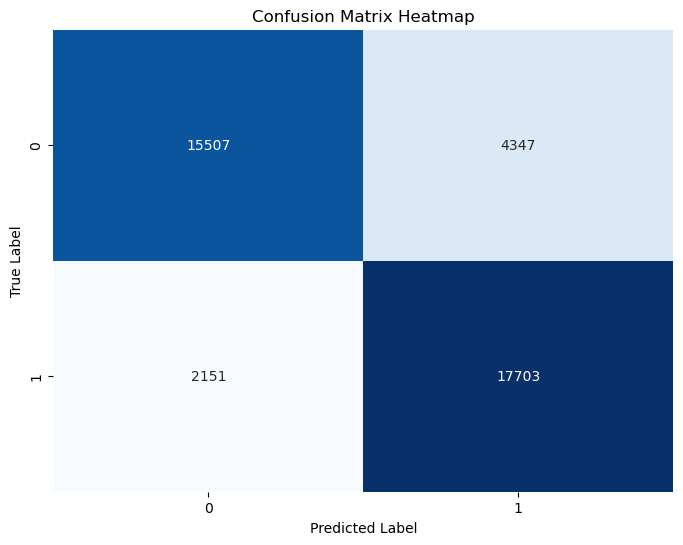

Root Mean Squared Error (RMSE): 0.4045
Residual Sum of Squares (RSS): 6498.0000
Mean Absolute Percentage Error (MAPE): 493027792388927.8125
ROC-AUC Score: 0.9159


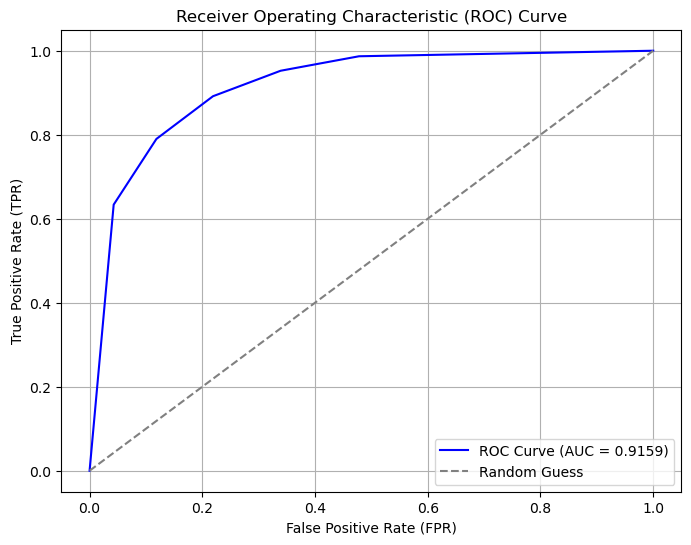

In [14]:
# Evaluate the Model

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_test, y_pred, zero_division=0)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred, zero_division=0)
print(f"Recall: {recall:.4f}")

# F1-Score
f1 = f1_score(y_test, y_pred, zero_division=0)
print(f"F1-Score: {f1:.4f}")

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# Cohen's Kappa Score
cohens_kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's Kappa Score: {cohens_kappa:.4f}")

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Residual Sum of Squares (RSS)
rss = np.sum((y_test - y_pred) ** 2)
print(f"Residual Sum of Squares (RSS): {rss:.4f}")

# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")

# Calculate ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Generate and Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [15]:
# Check for overfitting or underfitting
train_accuracy = accuracy_score(y_train, knn_model.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Determine model behavior
if train_accuracy > test_accuracy + 0.1:  
    print("The model might be overfitting (high training accuracy, low testing accuracy).")
elif test_accuracy > train_accuracy:
    print("The model might be underfitting (low accuracy on both training and testing sets).")
else:
    print("The model appears to be well-fitted.")

Training Accuracy: 0.8905
Testing Accuracy: 0.8364
The model appears to be well-fitted.


In [16]:
# Train the KNN Model
knn_model = KNeighborsClassifier(n_neighbors=10, metric='minkowski', p=2)  
knn_model.fit(X_train, y_train)
print("\nK-Nearest Neighbors model trained successfully.")


K-Nearest Neighbors model trained successfully.


In [17]:
# Make Predictions
y_pred = knn_model.predict(X_test)  # Generate predictions
y_pred_prob = knn_model.predict_proba(X_test)[:, 1]  # For ROC-AUC (if binary classification)# Make Predictions
y_pred = knn_model.predict(X_test)  # Generate predictions
y_pred_prob = knn_model.predict_proba(X_test)[:, 1]  # For ROC-AUC (if binary classification)


Accuracy: 0.8155
Precision: 0.8043
Recall: 0.8340
F1-Score: 0.8189
Matthews Correlation Coefficient: 0.6314
Cohen's Kappa Score: 0.6310


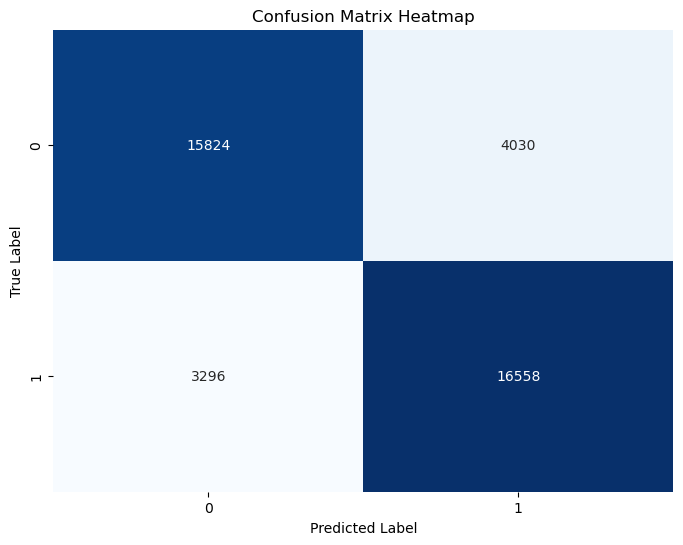

Root Mean Squared Error (RMSE): 0.4295
Residual Sum of Squares (RSS): 7326.0000
Mean Absolute Percentage Error (MAPE): 457074304883225.0000
ROC-AUC Score: 0.9042


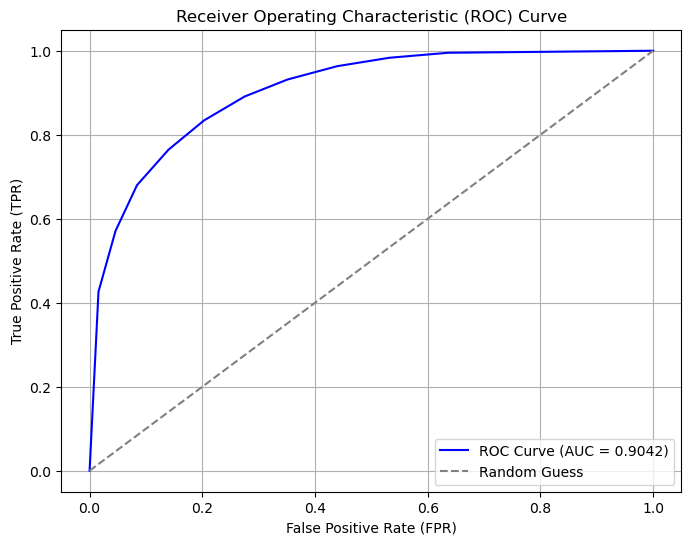

In [18]:
# Evaluate the Model

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_test, y_pred, zero_division=0)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred, zero_division=0)
print(f"Recall: {recall:.4f}")

# F1-Score
f1 = f1_score(y_test, y_pred, zero_division=0)
print(f"F1-Score: {f1:.4f}")

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# Cohen's Kappa Score
cohens_kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's Kappa Score: {cohens_kappa:.4f}")

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Residual Sum of Squares (RSS)
rss = np.sum((y_test - y_pred) ** 2)
print(f"Residual Sum of Squares (RSS): {rss:.4f}")

# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")

# Calculate ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Generate and Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [19]:
# Check for overfitting or underfitting
train_accuracy = accuracy_score(y_train, knn_model.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Determine model behavior
if train_accuracy > test_accuracy + 0.1:  
    print("The model might be overfitting (high training accuracy, low testing accuracy).")
elif test_accuracy > train_accuracy:
    print("The model might be underfitting (low accuracy on both training and testing sets).")
else:
    print("The model appears to be well-fitted.")

Training Accuracy: 0.8533
Testing Accuracy: 0.8155
The model appears to be well-fitted.
